In [1]:
#---------------------------------Standard Imports--------------------------
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# This relates to plotting datetime values with matplotlib:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [4]:
#-----------------------------Load Dataset----------------------------------
df = pd.read_csv('C:/Users/A221LPEN/Desktop/Pytorch_for_Deep_Learning/PYTORCH_NOTEBOOKS/myCodes/Data/TimeSeriesData/Alcohol_Sales.csv',index_col=0,parse_dates=True)

In [5]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [6]:
df.tail()

,S4248SM144NCEN
DATE,
2018-09-01,12396
2018-10-01,13914
2018-11-01,14174
2018-12-01,15504
2019-01-01,10718


In [7]:
len(df)

325

In [8]:
#drop null values
df.dropna(inplace=True)
len(df)
#if len same, it means no null values

325

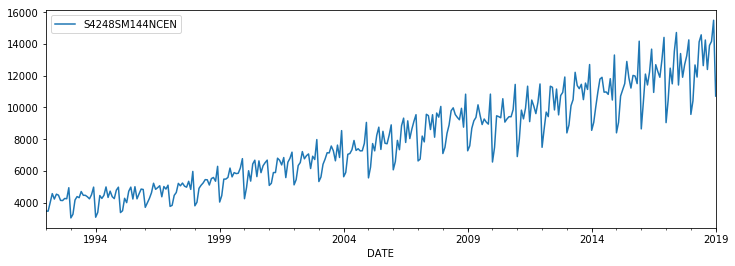

In [9]:
#----------------------------Plot Time Series Data--------------------------
df.plot(figsize=(12,4))

In [10]:
#general increasing sales over the years

In [11]:
#-------------------------Prepare the dataset-------------------------------
#convert string to float (extract values form csv)
y = df['S4248SM144NCEN'].values.astype(float)

In [12]:
y

array([ 3459.,  3458.,  4002.,  4564.,  4221.,  4529.,  4466.,  4137.,
        4126.,  4259.,  4240.,  4936.,  3031.,  3261.,  4160.,  4377.,
        4307.,  4696.,  4458.,  4457.,  4364.,  4236.,  4500.,  4974.,
        3075.,  3377.,  4443.,  4261.,  4460.,  4985.,  4324.,  4719.,
        4374.,  4248.,  4784.,  4971.,  3370.,  3484.,  4269.,  3994.,
        4715.,  4974.,  4223.,  5000.,  4235.,  4554.,  4851.,  4826.,
        3699.,  3983.,  4262.,  4619.,  5219.,  4836.,  4941.,  5062.,
        4365.,  5012.,  4850.,  5097.,  3758.,  3825.,  4454.,  4635.,
        5210.,  5057.,  5231.,  5034.,  4970.,  5342.,  4831.,  5965.,
        3796.,  4019.,  4898.,  5090.,  5237.,  5447.,  5435.,  5107.,
        5515.,  5583.,  5346.,  6286.,  4032.,  4435.,  5479.,  5483.,
        5587.,  6176.,  5621.,  5889.,  5828.,  5849.,  6180.,  6771.,
        4243.,  4952.,  6008.,  5353.,  6435.,  6673.,  5636.,  6630.,
        5887.,  6322.,  6520.,  6678.,  5082.,  5216.,  5893.,  5894.,
      

In [13]:
# Define a test size, 12 monts in a year
test_size = 12

In [14]:
# Create train and test sets
train_set = y[:-test_size]
test_set = y[-test_size:]

In [15]:
test_set

array([10415., 12683., 11919., 14138., 14583., 12640., 14257., 12396.,
       13914., 14174., 15504., 10718.])

In [16]:
-------------------#Normalize the data--------------------------------------
from sklearn.preprocessing import MinMaxScaler

# Instantiate a scaler with a feature range from -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))

In [17]:
# Normalize the training set
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

In [18]:
train_norm.min()

-1.0

In [19]:
train_norm.max()

1.0

In [20]:
train_norm.mean()

-0.2041940178388313

In [21]:
type(train_norm)

numpy.ndarray

In [22]:
#--------------------------Prepare data for LSTM----------------------------
# Convert train_norm from an array to a tensor
train_norm = torch.FloatTensor(train_norm).view(-1)

# Define a window size
window_size = 12

# Define function to create seq/label tuples
def input_data(seq,ws):  # ws is the window size
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

# Apply the input_data function to train_norm
train_data = input_data(train_norm,window_size)
len(train_data)  # this should equal 325-12-12

301

In [23]:
# Display the first seq/label tuple in the train data
train_data[0]

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901, -0.7933, -0.6743]),
 tensor([-1.]))

In [24]:
#-------------------------Define the model---------------------------------
#LSTM layer of size (1,100).

class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]  # we only want the last value

In [25]:
#---------Instantiate the model, define loss and optimization functions-----
torch.manual_seed(101)
model = LSTMnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [26]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

   400
 40000
   400
   400
   100
     1
______
 41301


In [27]:
#-----------------------------Train the model-------------------------------
epochs = 100

import time
start_time = time.time()

for epoch in range(epochs):
    
    # extract the sequence & label from the training data
    for seq, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.25314346
Epoch:  2 Loss: 0.37523898
Epoch:  3 Loss: 0.39012098
Epoch:  4 Loss: 0.34949699
Epoch:  5 Loss: 0.33077881
Epoch:  6 Loss: 0.33230731
Epoch:  7 Loss: 0.32667691
Epoch:  8 Loss: 0.32077038
Epoch:  9 Loss: 0.30651760
Epoch: 10 Loss: 0.29517007
Epoch: 11 Loss: 0.26913929
Epoch: 12 Loss: 0.25979409
Epoch: 13 Loss: 0.24599977
Epoch: 14 Loss: 0.22227746
Epoch: 15 Loss: 0.18593749
Epoch: 16 Loss: 0.18445566
Epoch: 17 Loss: 0.17432530
Epoch: 18 Loss: 0.25822252
Epoch: 19 Loss: 0.22420511
Epoch: 20 Loss: 0.23121914
Epoch: 21 Loss: 0.19758883
Epoch: 22 Loss: 0.18989050
Epoch: 23 Loss: 0.21044919
Epoch: 24 Loss: 0.16945958
Epoch: 25 Loss: 0.14590861
Epoch: 26 Loss: 0.11834971
Epoch: 27 Loss: 0.00016216
Epoch: 28 Loss: 0.00644971
Epoch: 29 Loss: 0.05049752
Epoch: 30 Loss: 0.01273268
Epoch: 31 Loss: 0.03061030
Epoch: 32 Loss: 0.03195733
Epoch: 33 Loss: 0.02156793
Epoch: 34 Loss: 0.01352598
Epoch: 35 Loss: 0.01553653
Epoch: 36 Loss: 0.00003048
Epoch: 37 Loss: 0.00024998
E

In [28]:
#---------------------Prediction&Compare to known test set------------------
future = 12

# Add the last window of training values to the list of predictions
preds = train_norm[-window_size:].tolist()

# Set the model to evaluation mode
model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

In [29]:
# Display predicted values
preds[window_size:]    # equivalent to preds[-future:]

[0.21764472126960754,
 0.7362536787986755,
 0.42575034499168396,
 0.8574904799461365,
 1.24961256980896,
 0.32853081822395325,
 0.8707497715950012,
 0.6814860105514526,
 0.601524293422699,
 0.9176154732704163,
 0.8960760235786438,
 0.18404555320739746]

In [30]:
#---------------------------Invert Normalization----------------------------
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[10153.61279707],
       [13187.21589413],
       [11370.92664303],
       [13896.39056244],
       [16190.1087271 ],
       [10802.2410212 ],
       [13973.95078894],
       [12866.85241872],
       [12399.11635438],
       [14248.0917109 ],
       [14122.09669992],
       [ 9957.07446349]])

In [31]:
df['S4248SM144NCEN'][-12:]

DATE
2018-02-01    10415
2018-03-01    12683
2018-04-01    11919
2018-05-01    14138
2018-06-01    14583
2018-07-01    12640
2018-08-01    14257
2018-09-01    12396
2018-10-01    13914
2018-11-01    14174
2018-12-01    15504
2019-01-01    10718
Name: S4248SM144NCEN, dtype: int64

In [32]:
#----------------------------Plot Results-----------------------------------
# Remember that the stop date has to be later than the last predicted value.
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]').astype('datetime64[D]')
x

array(['2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
       '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
       '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01'],
      dtype='datetime64[D]')

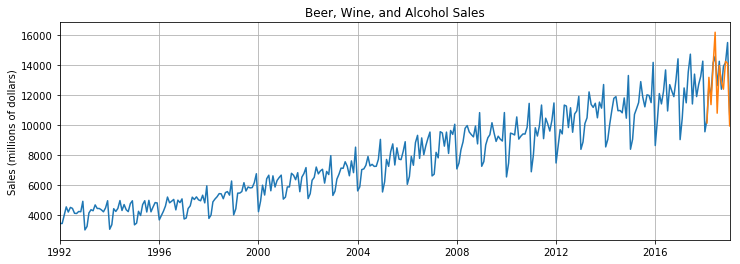

In [33]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions)
plt.show()

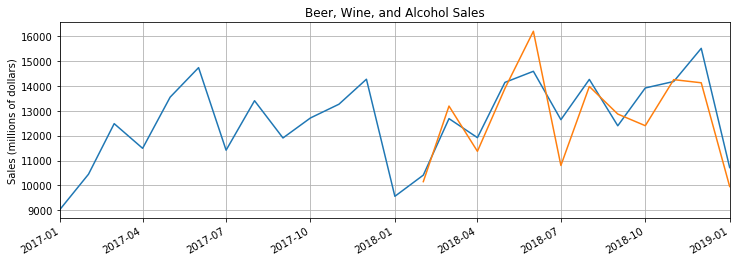

In [34]:
# Plot the end of the graph
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

# Select the end of the graph with slice notation:
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions)
plt.show()

In [35]:
#--------------------Forecast into an unknown future-----------------------
# continue training the model using the entire dataset, and predict 12 steps into the future.
epochs = 100

# set model to back to training mode
model.train()

# feature scale the entire dataset
y_norm = scaler.fit_transform(y.reshape(-1, 1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm,window_size)

import time
start_time = time.time()

for epoch in range(epochs):
    
    # train on the full set of sequences
    for seq, y_train in all_data:  
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.01454567
Epoch:  2 Loss: 0.01350383
Epoch:  3 Loss: 0.02643331
Epoch:  4 Loss: 0.01324219
Epoch:  5 Loss: 0.01439027
Epoch:  6 Loss: 0.01231953
Epoch:  7 Loss: 0.01169418
Epoch:  8 Loss: 0.01061528
Epoch:  9 Loss: 0.00724249
Epoch: 10 Loss: 0.00424754
Epoch: 11 Loss: 0.00208558
Epoch: 12 Loss: 0.00440567
Epoch: 13 Loss: 0.01001350
Epoch: 14 Loss: 0.00601961
Epoch: 15 Loss: 0.00487102
Epoch: 16 Loss: 0.00251737
Epoch: 17 Loss: 0.00400521
Epoch: 18 Loss: 0.00497501
Epoch: 19 Loss: 0.00461044
Epoch: 20 Loss: 0.00193556
Epoch: 21 Loss: 0.00038231
Epoch: 22 Loss: 0.00528781
Epoch: 23 Loss: 0.00042755
Epoch: 24 Loss: 0.00195656
Epoch: 25 Loss: 0.00191549
Epoch: 26 Loss: 0.00084451
Epoch: 27 Loss: 0.00021586
Epoch: 28 Loss: 0.00923860
Epoch: 29 Loss: 0.00273661
Epoch: 30 Loss: 0.00330967
Epoch: 31 Loss: 0.00159039
Epoch: 32 Loss: 0.00249826
Epoch: 33 Loss: 0.00335327
Epoch: 34 Loss: 0.00662615
Epoch: 35 Loss: 0.00236142
Epoch: 36 Loss: 0.00001399
Epoch: 37 Loss: 0.00416735
E

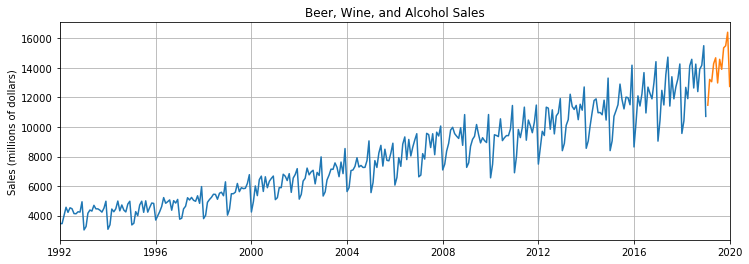

In [36]:
#------------------------Predict future values, plot the result-------------
window_size = 12
future = 12
L = len(y)

preds = y_norm[-window_size:].tolist()

model.eval()
for i in range(future):  
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        # Reset the hidden parameters here!
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))  
        preds.append(model(seq).item())

# Inverse-normalize the prediction set
true_predictions = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

# PLOT THE RESULT
# Set a data range for the predicted data.
# Remember that the stop date has to be later than the last predicted value.
x = np.arange('2019-02-01', '2020-02-01', dtype='datetime64[M]').astype('datetime64[D]')

plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions[window_size:])
plt.show()

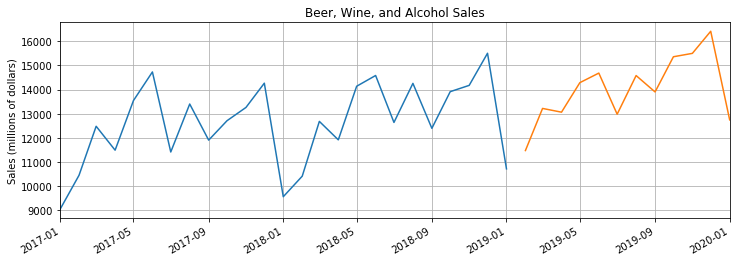

In [37]:
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions[window_size:])
plt.show()